This example conducts a statistical analysis of the initial optwrf database in an attempt to tease out relationships among the different parameters.

Last Updated by Jeffrey Sward on April 15, 2020.

In [2]:
import csv
import datetime
import random
import sys
import time

import seaborn as sns
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [59]:
# dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
# df = pd.read_csv(infile, parse_dates=['datetime'], date_parser=dateparse)

dateparse = lambda x: pd.datetime.strptime(x, '%b %d %Y')
data = pd.read_csv('./optwrf_database_041620_11am.csv', parse_dates=['start_date'], date_parser=dateparse)

In [60]:
data

,start_date,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,sf_sfclay_physics,fitness,runtime
0,2011-12-29,2,31,2,3,5,93,1,6.022000e+23,00:00:00
1,2011-11-27,13,5,7,5,5,14,1,2.034423e+03,4:39:34.359051
2,2011-09-01,14,4,7,1,1,11,2,6.022000e+23,0:00:00.042498
3,2011-04-06,18,1,5,7,9,16,1,6.022000e+23,6:00:01.733799
4,2011-05-02,14,7,1,7,8,94,1,6.022000e+23,6:00:06.829933
...,...,...,...,...,...,...,...,...,...,...
600,2011-04-01,6,1,4,4,12,16,1,1.026276e+03,01h 03m 39s
601,2011-01-08,18,5,4,7,8,99,1,7.317493e+02,01h 49m 53s
602,2011-02-08,18,5,4,4,8,99,1,8.219122e+02,01h 41m 17s
603,2011-01-20,6,5,4,7,8,99,1,3.855153e+02,01h 56m 06s


In [61]:
data['fitness'].values[data['fitness'] > 6 * 10 ** 23] = np.nan
data

,start_date,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,sf_sfclay_physics,fitness,runtime
0,2011-12-29,2,31,2,3,5,93,1,NaN,00:00:00
1,2011-11-27,13,5,7,5,5,14,1,2034.423190,4:39:34.359051
2,2011-09-01,14,4,7,1,1,11,2,NaN,0:00:00.042498
3,2011-04-06,18,1,5,7,9,16,1,NaN,6:00:01.733799
4,2011-05-02,14,7,1,7,8,94,1,NaN,6:00:06.829933
...,...,...,...,...,...,...,...,...,...,...
600,2011-04-01,6,1,4,4,12,16,1,1026.276285,01h 03m 39s
601,2011-01-08,18,5,4,7,8,99,1,731.749257,01h 49m 53s
602,2011-02-08,18,5,4,4,8,99,1,821.912185,01h 41m 17s
603,2011-01-20,6,5,4,7,8,99,1,385.515278,01h 56m 06s


In [62]:
data.sort_values(by='fitness')

,start_date,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,sf_sfclay_physics,fitness,runtime
428,2011-12-13,18,5,4,7,8,99,1,372.259962,01h 44m 40s
603,2011-01-20,6,5,4,7,8,99,1,385.515278,01h 56m 06s
190,2011-12-13,1,5,1,1,8,5,2,390.165664,01h 37m 48s
472,2011-12-13,6,1,4,4,12,16,1,391.455634,02h 09m 12s
579,2011-12-13,6,1,4,4,12,99,1,391.963415,02h 08m 31s
...,...,...,...,...,...,...,...,...,...,...
576,2011-11-12,18,1,2,7,8,99,1,NaN,06h 00m 06s
584,2011-11-14,5,1,4,7,8,99,1,NaN,06h 00m 07s
589,2011-01-02,5,1,4,7,8,99,1,NaN,06h 00m 00s
592,2011-10-01,18,1,4,7,8,99,1,NaN,06h 00m 07s


In [7]:
data = data.sort_values(by='start_date')
data

,start_date,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,sf_sfclay_physics,fitness,runtime
37,2011-01-01,8,4,99,5,9,7,1,1432.446184,5:22:22.863760
33,2011-01-01,18,3,4,7,9,7,1,NaN,6:00:02.341057
203,2011-01-01,6,5,99,7,9,1,1,NaN,06h 00m 08s
305,2011-01-02,11,4,4,2,12,5,1,710.210094,03h 44m 48s
361,2011-01-02,6,1,4,4,12,16,1,630.713944,01h 14m 12s
...,...,...,...,...,...,...,...,...,...,...
129,2011-12-27,17,7,1,2,7,1,1,1033.922806,02h 16m 35s
0,2011-12-29,2,31,2,3,5,93,1,NaN,00:00:00
108,2011-12-30,2,4,24,5,9,94,1,890.534170,05h 09m 23s
56,2011-12-30,10,31,3,4,7,5,1,NaN,00h 52m 31s


In [25]:
def format_plot(xlab='xlabel', ylab='ylabel'):
    # find and format dates
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    date_fmt = mdates.DateFormatter('%b')

    # format the ticks
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(date_fmt)
    ax.xaxis.label.set_fontsize(14)
    ax.yaxis.label.set_fontsize(14)

    # round to nearest month
    datemin = np.datetime64(data['start_date'].iloc[0], 'm')
    datemax = np.datetime64(data['start_date'].iloc[-1], 'm') + np.timedelta64(1, 'm')
    ax.set_xlim(datemin, datemax)

    # format the coords message box
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.grid(True)

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    fig.autofmt_xdate()
    
    # format x and y labels
    plt.xlabel(xlab, fontsize=18)
    plt.ylabel(ylab, fontsize=18)

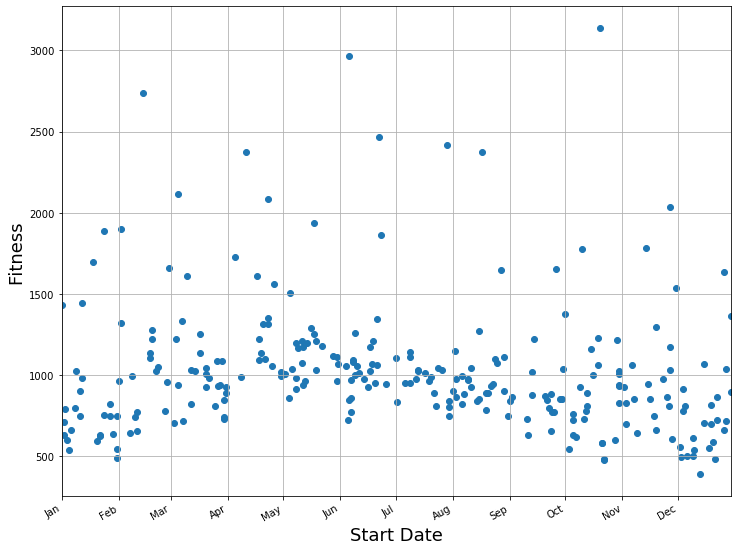

In [26]:
# Plot start_date vs fitness
start_date = data.start_date
fitness = data.fitness

fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(start_date, fitness)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

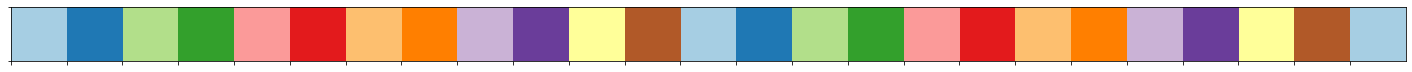

In [12]:
cmap1 = sns.color_palette('Paired',25)
sns.palplot(cmap1)

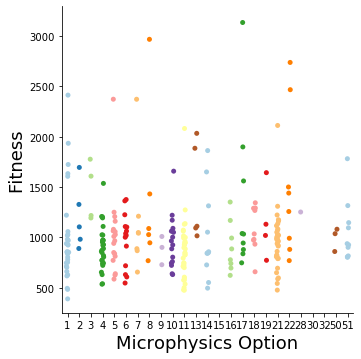

In [58]:
# Plot microphysics option vs. fitness
sns.catplot(x='mp_physics', y='fitness', data=data, palette=cmap1)
plt.xlabel('Microphysics Option', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvmp.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

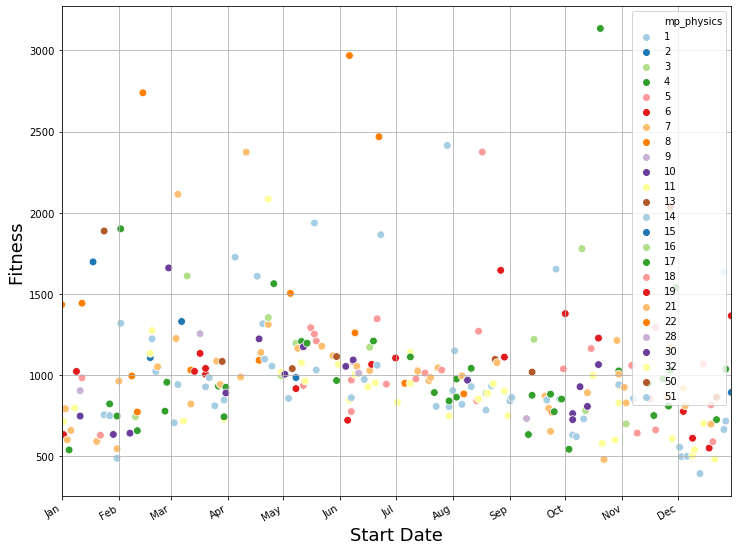

In [28]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(start_date, fitness, hue=data.mp_physics, legend='full', palette=cmap1, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_mp.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

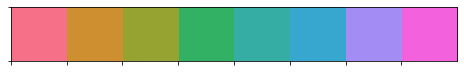

In [29]:
cmap2 = sns.husl_palette(8)
sns.palplot(cmap2)

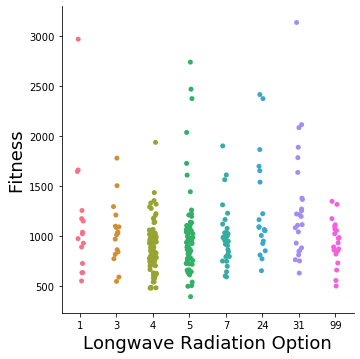

In [30]:
# Plot longwave radiation option vs. fitness
sns.catplot(x='ra_lw_physics', y='fitness', data=data, palette=cmap2)
plt.xlabel('Longwave Radiation Option', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvralw.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

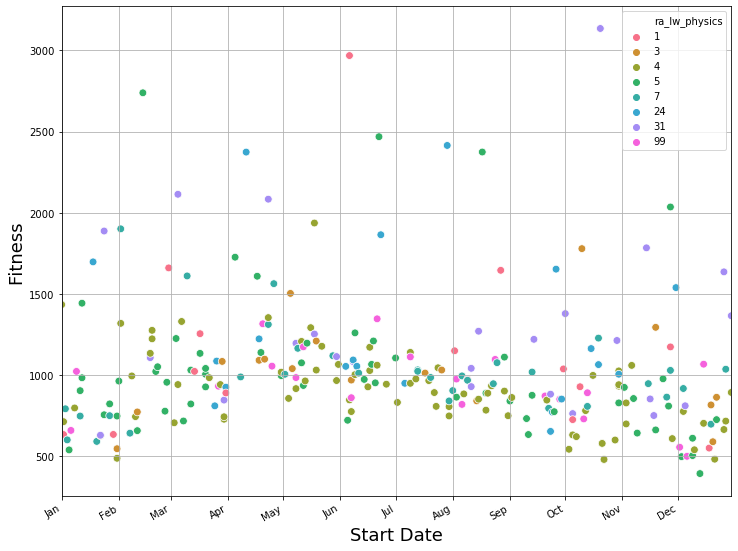

In [31]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(start_date, fitness, hue=data.ra_lw_physics, legend="full", palette=cmap2, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_ralw.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

In [32]:
# Paired; n = 8; desat = 0.60
cmap3 = sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

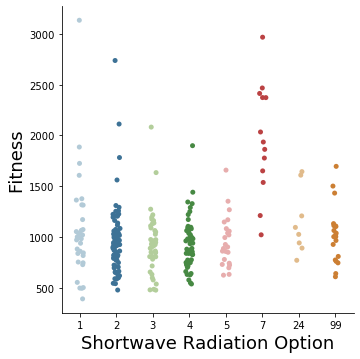

In [33]:
# Plot shortwave radiaiton option vs. fitness
sns.catplot(x='ra_sw_physics', y='fitness', data=data, palette=cmap3);
plt.xlabel('Shortwave Radiation Option', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvrasw.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

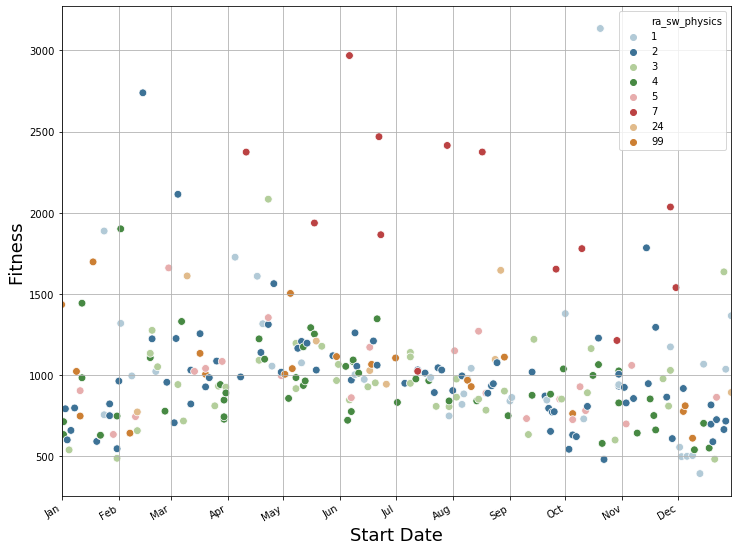

In [34]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(start_date, fitness, hue=data.ra_sw_physics, legend="full", palette=cmap3, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_rasw.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

In [35]:
# Set2; n = 6; desat = 0.80
cmap4 = sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

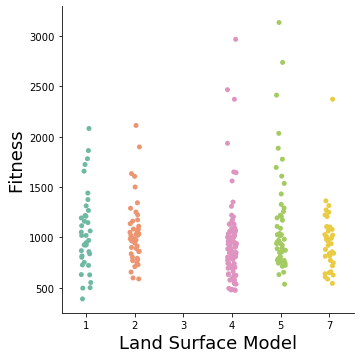

In [39]:
# Plot surface physics option vs. fitness
sns.catplot(x='sf_surface_physics', y='fitness', data=data, palette=cmap4)
plt.xlabel('Land Surface Model', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvlsm.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

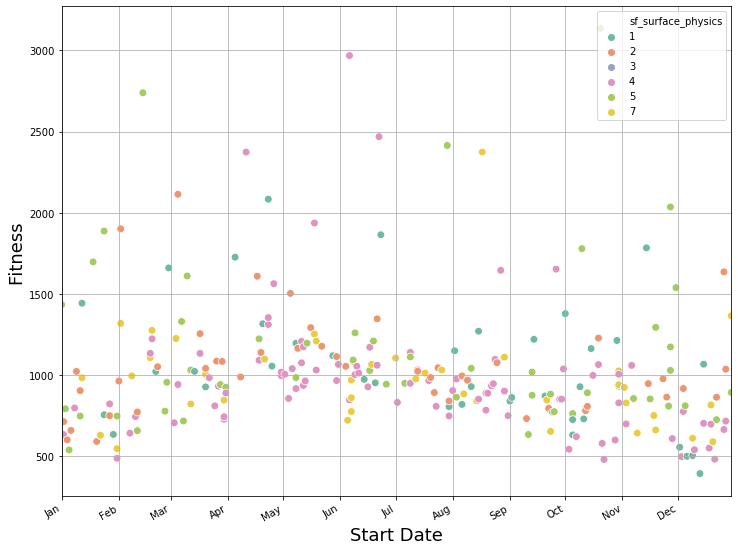

In [40]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(start_date, fitness, hue=data.sf_surface_physics, legend="full", palette=cmap4, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_lsm.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

In [41]:
# Accent; n = 11; desat = 0.70
cmap5 = sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

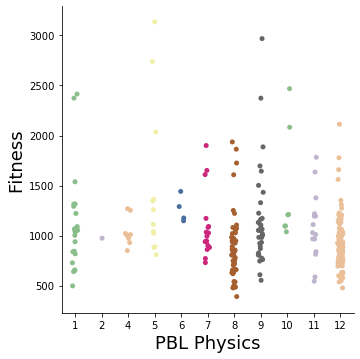

In [43]:
# Plot planetary boundary layer option vs. fitness
sns.catplot(x='bl_pbl_physics', y='fitness', data=data, palette=cmap5)
plt.xlabel('PBL Physics', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvpbl.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

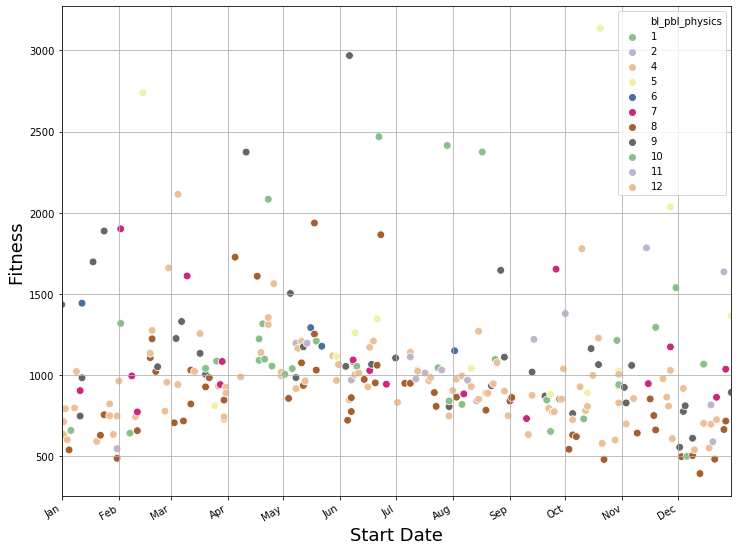

In [44]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(start_date, fitness, hue=data.bl_pbl_physics, legend="full", palette=cmap5, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_pbl.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

In [45]:
# Dark2; n = 14; desat = 0.9
cmap6 = sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

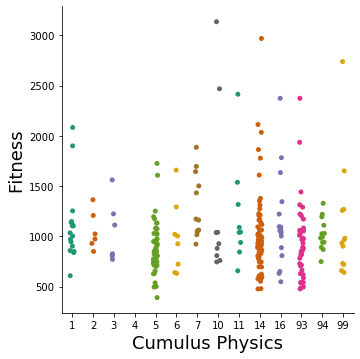

In [52]:
# Plot cumulus option vs. fitness
sns.catplot(x='cu_physics', y='fitness', data=data, palette=cmap6)
plt.xlabel('Cumulus Physics', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvcu.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

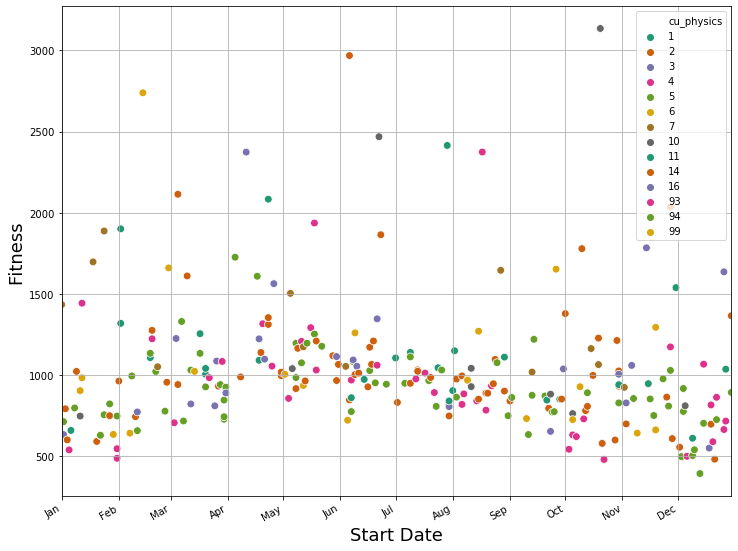

In [53]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(start_date, fitness, hue=data.cu_physics, legend="full", palette=cmap6, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_cu.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

In [54]:
# Set1; n = 5; desat = 1.00
cmap7 = sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

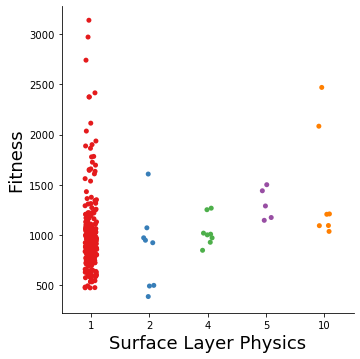

In [55]:
# Plot surface layer option vs. Fitness
sns.catplot(x='sf_sfclay_physics', y='fitness', data=data, palette=cmap7)
plt.xlabel('Surface Layer Physics', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvsfclay.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

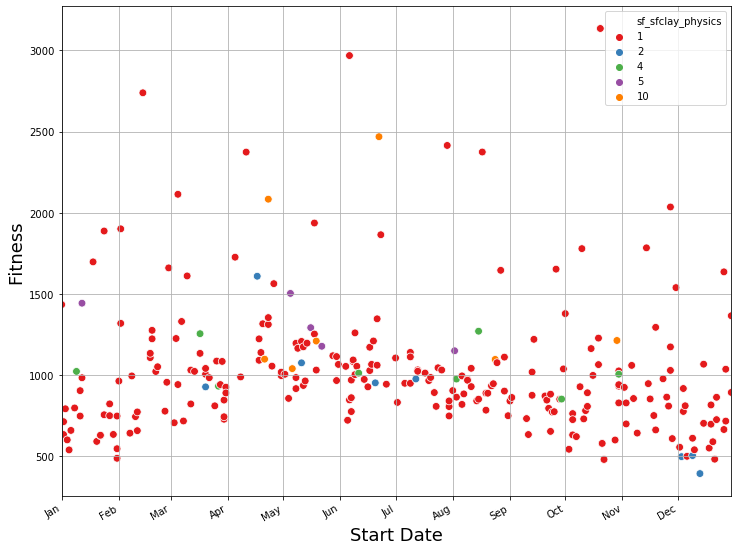

In [56]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(start_date, fitness, hue=data.sf_sfclay_physics, legend="full", palette=cmap7, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_sfclay.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

Text(0, 0.5, 'Fitness')

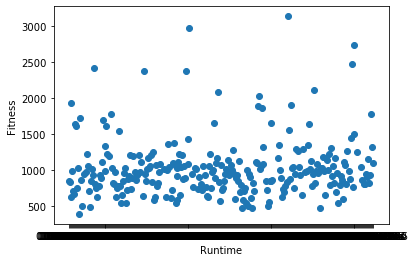

In [131]:
# Plot start_date vs fitness
data = data.sort_values(by='mp_physics')
runtime = data.runtime
fitness = data.fitness

fig, ax = plt.subplots()
plt.scatter(runtime, fitness)
plt.xlabel('Runtime')
plt.ylabel('Fitness')

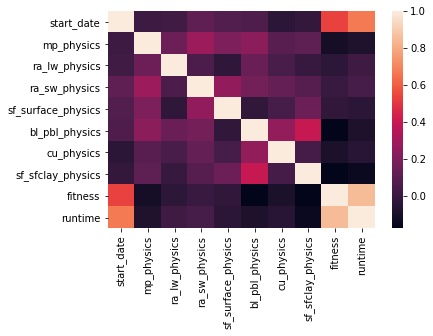

In [57]:
# Plot an overall heatmap
corr_matrix = data.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
sns.heatmap(corr_matrix)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Heatmap_overall.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

In [ ]:
# # Create more detailed heatmaps
# ra_data = data[['ra_lw_physics', 'ra_sw_physics', 'fitness']]
# ra_data

# temp = ra_data.drop(columns=['ra_sw_physics'])
# temp = temp.groupby('ra_lw_physics').mean()
# temp

# temp = ra_data.drop(columns=['ra_lw_physics'])
# temp = temp.groupby('ra_sw_physics').mean()
# temp